In [16]:
!pwd

/Users/apple/git/large_eye_tracking/analysis_code


In [18]:
# Cell 1: imports, paths, output dir (reuse feat; do NOT rebuild)
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ROOT = Path('/Users/apple/git/large_eye_tracking')
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

DATA_DIR = ROOT / 'data'
INTERM_DATA_DIR = DATA_DIR / 'intermediate_data'
RESULT_DIR = ROOT / 'analysis_results'

OUT_DIR = RESULT_DIR / 'plots' / 'search_boxplots_v2_nb'
OUT_DIR.mkdir(parents=True, exist_ok=True)
sns.set_theme(style='whitegrid')

feat = pd.read_csv(RESULT_DIR / 'pca' / 'search' / 'features_pca_search.csv')
feat['ID'] = feat['ID'].astype(str)

acc = pd.read_csv(INTERM_DATA_DIR / 'search' / 'accuracy_with_gaze.csv')
acc['ID'] = acc['ID'].astype(str)

# Merge accuracy metadata
keep_acc = [c for c in ['ID','Combined SDT','Target location','Shape','Response outcome','Gaze hit'] if c in acc.columns]
df = feat.merge(acc[keep_acc].drop_duplicates(), on='ID', how='left')

# If Shape missing, merge from participant_info
if 'Shape' not in df.columns or df['Shape'].isna().all():
    pinf = pd.read_csv(INTERM_DATA_DIR / 'search' / 'participant_info.csv', usecols=['ID','Shape'])
    pinf['ID'] = pinf['ID'].astype(str)
    df = df.merge(pinf, on='ID', how='left', suffixes=('','_pp'))
    if 'Shape_pp' in df.columns:
        df['Shape'] = df['Shape'].fillna(df['Shape_pp'])
        df = df.drop(columns=['Shape_pp'])

# Demographics
pp = pd.read_csv(INTERM_DATA_DIR / 'search' / 'participant_info.csv', usecols=['ID','Age','Gender'])
pp['ID'] = pp['ID'].astype(str)
df = df.merge(pp, on='ID', how='left')

# Helpers
df['Age_group'] = pd.cut(pd.to_numeric(df['Age'], errors='coerce'),
                         bins=[0,20,40,200], labels=['6-20','20-40','40+'], right=False)

if 'fix_dur_cv' not in df.columns and {'fix_dur_mean','fix_dur_std'}.issubset(df.columns):
    mean_ = pd.to_numeric(df['fix_dur_mean'], errors='coerce').replace(0, np.nan)
    std_  = pd.to_numeric(df['fix_dur_std'], errors='coerce')
    df['fix_dur_cv'] = (std_/mean_).replace([np.inf,-np.inf], np.nan)

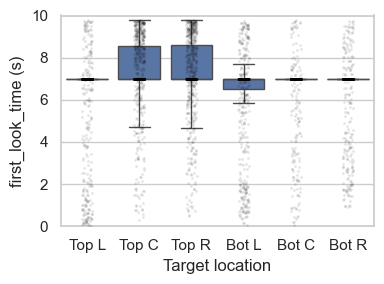

In [59]:
# Cell 2: Onset boxplot by Target location (six) — replace previous histogram
if {'first_look_time','Target location'}.issubset(df.columns):
    order_pos = ['Top L','Top C','Top R','Bot L','Bot C','Bot R']
    d = df.dropna(subset=['first_look_time','Target location']).copy()
    d = d[d['Target location'].isin(order_pos)]

    plt.figure(figsize=(4,3))
    sns.boxplot(data=d, x='Target location', y='first_look_time', order=order_pos, showfliers=False)
    sns.stripplot(data=d, x='Target location', y='first_look_time', order=order_pos, color='black', alpha=0.1, size=2)
    
    plt.xlabel('Target location')
    plt.ylabel('first_look_time (s)')
    plt.ylim(0, 10)

    plt.tight_layout()
    plt.show()

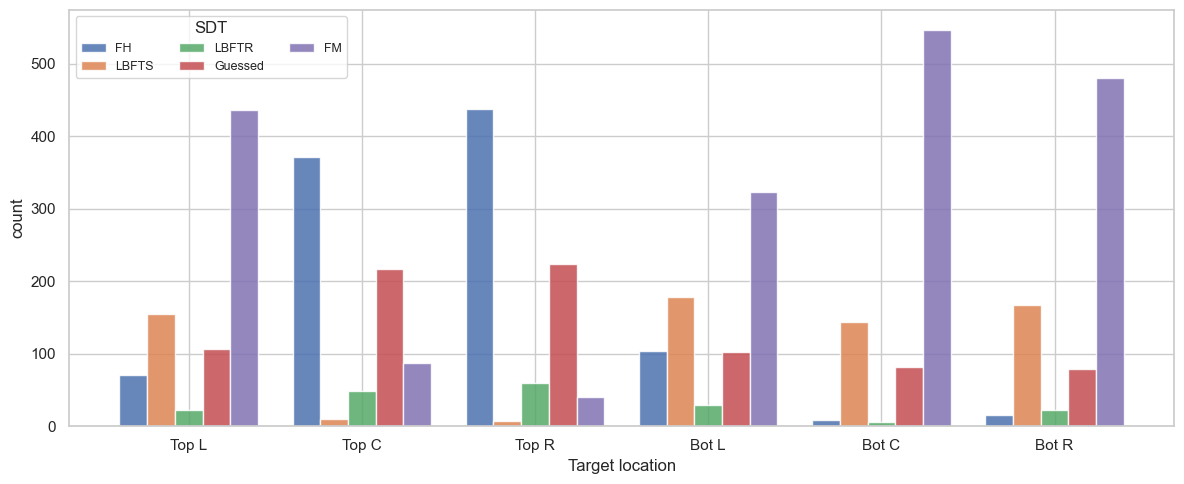

In [21]:
# Cell 3: Combined SDT distribution by Target location — one figure, same X-axis (grouped bars, 5 categories)
if {'Combined SDT','Target location'}.issubset(df.columns):
    pos_order = ['Top L','Top C','Top R','Bot L','Bot C','Bot R']
    cat_order = ['Full hit','LBFTS','Misremembered/LBFTS','Guessed (not fixated)','Full miss']
    # Short labels
    cat_short_map = {
        'Full hit': 'FH',
        'LBFTS': 'LBFTS',
        'Misremembered/LBFTS': 'LBFTR',
        'Guessed (not fixated)': 'Guessed',
        'Full miss': 'FM',
    }
    x_labels = [cat_short_map.get(c, c) for c in cat_order]

    # Build counts matrix: rows=positions, cols=categories
    counts = np.zeros((len(pos_order), len(cat_order)), dtype=int)
    for i, loc in enumerate(pos_order):
        dd = df[(df['Target location'] == loc) & (df['Combined SDT'].isin(cat_order))]
        vc = dd['Combined SDT'].value_counts()
        for j, cat in enumerate(cat_order):
            counts[i, j] = int(vc.get(cat, 0))
    # Plot grouped bars with positions on x-axis and SDT as legend
    fig, ax = plt.subplots(figsize=(12, 5))
    x = np.arange(len(pos_order), dtype=float)
    width = max(0.8 / len(cat_order), 0.08)
    offset_center = (len(cat_order) - 1) * width / 2.0
    for j, cat in enumerate(cat_order):
        ax.bar(x + (j * width) - offset_center, counts[:, j], width=width, label=x_labels[j], alpha=0.85)

    ax.set_xticks(x)
    ax.set_xticklabels(pos_order)
    ax.set_xlabel('Target location')
    ax.set_ylabel('count')
    ax.legend(title='SDT', ncols=3, fontsize=9)
    plt.tight_layout()
    plt.show()

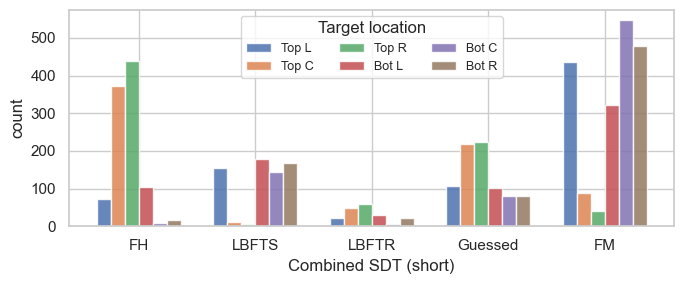

In [58]:
# Cell 3: Combined SDT distribution by Target location — one figure, same X-axis (grouped bars, 5 categories)
if {'Combined SDT','Target location'}.issubset(df.columns):
    pos_order = ['Top L','Top C','Top R','Bot L','Bot C','Bot R']
    cat_order = ['Full hit','LBFTS','Misremembered/LBFTS','Guessed (not fixated)','Full miss']
    # Short labels
    cat_short_map = {
        'Full hit': 'FH',
        'LBFTS': 'LBFTS',
        'Misremembered/LBFTS': 'LBFTR',
        'Guessed (not fixated)': 'Guessed',
        'Full miss': 'FM',
    }
    x_labels = [cat_short_map.get(c, c) for c in cat_order]

    # Build counts matrix: rows=positions, cols=categories
    counts = np.zeros((len(pos_order), len(cat_order)), dtype=int)
    for i, loc in enumerate(pos_order):
        dd = df[(df['Target location'] == loc) & (df['Combined SDT'].isin(cat_order))]
        vc = dd['Combined SDT'].value_counts()
        for j, cat in enumerate(cat_order):
            counts[i, j] = int(vc.get(cat, 0))
    # Plot grouped bars
    fig, ax = plt.subplots(figsize=(7, 3))
    x = np.arange(len(cat_order), dtype=float)
    width = 0.12
    offset_center = (len(pos_order) - 1) * width / 2.0
    for i, loc in enumerate(pos_order):
        ax.bar(x + (i * width) - offset_center, counts[i], width=width, label=loc, alpha=0.85)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel('Combined SDT (short)')
    ax.set_ylabel('count')
    ax.legend(title='Target location', ncols=3, fontsize=9)
    plt.tight_layout()
    plt.show()


In [46]:
# Ensure detection/correct flags exist for percent summaries
if 'Response hit' not in df.columns and 'Response outcome' in df.columns:
    df['Response hit'] = (df['Response outcome'] == 'Hit').astype(float)
if 'Gaze hit' in df.columns:
    df['Gaze hit'] = pd.to_numeric(df['Gaze hit'], errors='coerce')

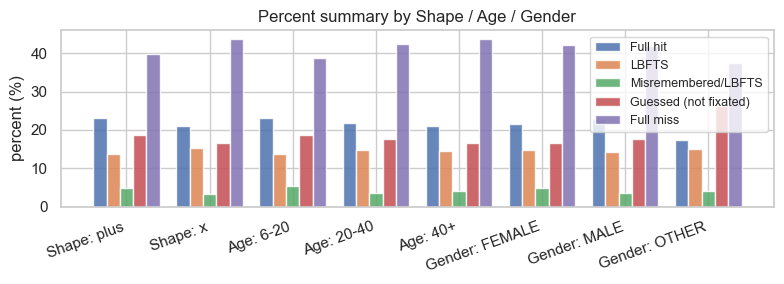

In [55]:
# Cell 3b: Percent summary bars on one figure (Combined SDT - 5 categories) — same X-axis, percentages
if 'Combined SDT' in df.columns:
    x_cats = ['Full hit','LBFTS','Misremembered/LBFTS','Guessed (not fixated)','Full miss']
    
    def _group_percent_sdt(frame: pd.DataFrame, key: str, groups: list[str]):
        out = []
        for g in groups:
            sub = frame[frame[key] == g]
            sdt = sub['Combined SDT'].astype(str)
            percentages = []
            for cat in x_cats:
                pct = (sdt == cat).mean()
                percentages.append(pct)
            out.append((g, np.array(percentages, dtype=float)))
        return out

    series = []
    shp_order = [s for s in ['plus','x'] if 'Shape' in df.columns and s in df['Shape'].dropna().unique()]
    if shp_order:
        series.append(('Shape', _group_percent_sdt(df, 'Shape', shp_order)))
    age_order = [a for a in ['6-20','20-40','40+'] if a in df['Age_group'].dropna().unique()]
    if age_order:
        series.append(('Age', _group_percent_sdt(df, 'Age_group', age_order)))
    g_order = [g for g in ['FEMALE','MALE','OTHER'] if 'Gender' in df.columns and g in df['Gender'].dropna().unique()]
    if g_order:
        series.append(('Gender', _group_percent_sdt(df, 'Gender', g_order)))

    if series:
        group_labels = []
        arrs = []
        for set_name, items in series:
            for name, arr in items:
                group_labels.append(f'{set_name}: {name}')
                arrs.append(arr)
        M = np.vstack(arrs) if arrs else np.zeros((0, len(x_cats)))
        n_groups = M.shape[0]
        xpos = np.arange(n_groups, dtype=float)
        width = max(0.8 / len(x_cats), 0.08)
        offset_center = (len(x_cats) - 1) * width / 2.0

        fig, ax = plt.subplots(figsize=(8, 3))
        for j, cat in enumerate(x_cats):
            ax.bar(xpos + (j * width) - offset_center, M[:, j] * 100.0, width=width, alpha=0.85, label=cat)
        ax.set_xticks(xpos)
        ax.set_xticklabels(group_labels, rotation=20, ha='right')
        ax.set_ylabel('percent (%)')
        ax.set_title('Percent summary by Shape / Age / Gender')
        ax.legend(fontsize=9, ncols=1)
        plt.tight_layout()
        plt.show()

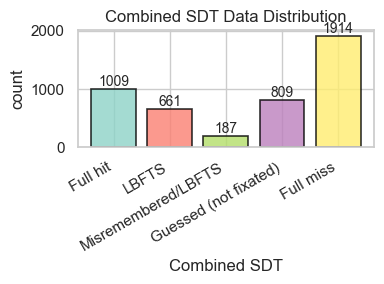

In [61]:
# Cell 3b_hist: Histogram of Combined SDT (5 categories) — data distribution
if 'Combined SDT' in df.columns:
    cat5 = ['Full hit','LBFTS','Misremembered/LBFTS','Guessed (not fixated)','Full miss']
    
    # Filter data
    dd = df[df['Combined SDT'].isin(cat5)].copy()
    
    # Get value counts
    counts = dd['Combined SDT'].value_counts().reindex(cat5, fill_value=0)
    
    # Plot histogram
    fig, ax = plt.subplots(figsize=(4, 3))
    colors = plt.cm.Set3(np.linspace(0, 1, len(cat5)))
    bars = ax.bar(range(len(cat5)), counts.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
    
    ax.set_xticks(range(len(cat5)))
    ax.set_xticklabels(cat5, rotation=30, ha='right')
    ax.set_ylabel('count')
    ax.set_xlabel('Combined SDT')
    ax.set_title('Combined SDT Data Distribution')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, counts.values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(val)}',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    

In [40]:
series

[('Shape',
  [('plus',
    array([0.41481481, 0.35829343, 0.18458859, 0.18676535, 0.39791032])),
   ('x',
    array([0.39606127, 0.32516411, 0.18555799, 0.16630197, 0.43763676]))]),
 ('Age',
  [('6-20',
    array([0.42366757, 0.35198556, 0.19133574, 0.18772563, 0.38808664])),
   ('20-40',
    array([0.40105434, 0.34306569, 0.18248175, 0.175588  , 0.42335766])),
   ('40+',
    array([0.39622642, 0.32738095, 0.18452381, 0.16666667, 0.43650794]))]),
 ('Gender',
  [('FEMALE',
    array([0.41084011, 0.33640303, 0.19447454, 0.16630553, 0.42253521])),
   ('MALE',
    array([0.40570969, 0.34606109, 0.17765273, 0.17564309, 0.41840836])),
   ('OTHER',
    array([0.36290323, 0.33870968, 0.18951613, 0.26209677, 0.375     ]))])]

In [42]:
'''# %%
# Cell 3c: Onset boxplots for Shape / Age / Gender in one figure (subplots)
subplots = []
if 'Shape' in df.columns:
    subplots.append(('Shape', [s for s in ['plus','x'] if s in df['Shape'].dropna().unique()]))
if 'Age_group' in df.columns:
    subplots.append(('Age_group', [a for a in ['6-20','20-40','40+'] if a in df['Age_group'].dropna().unique()]))
if 'Gender' in df.columns:
    subplots.append(('Gender', [g for g in ['FEMALE','MALE','OTHER'] if g in df['Gender'].dropna().unique()]))
if 'first_look_time' in df.columns and subplots:
    rows = 1; cols = len(subplots)
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4), squeeze=False)
    for i, (key, order) in enumerate(subplots):
        ax = axes[0][i]
        dsub = df.dropna(subset=[key, 'first_look_time'])
        if not order:
            ax.axis('off'); continue
        sns.boxplot(data=dsub[dsub[key].isin(order)], x=key, y='first_look_time', order=order, showfliers=False, ax=ax)
        # sns.stripplot(data=dsub[dsub[key].isin(order)], x=key, y='first_look_time', order=order, color='black', alpha=0.2, size=2, ax=ax)
        ax.set_xlabel(key); ax.set_ylabel('first_look_time (s)')
        ax.tick_params(axis='x', rotation=15)
    plt.tight_layout()
    plt.show()'''

"# %%\n# Cell 3c: Onset boxplots for Shape / Age / Gender in one figure (subplots)\nsubplots = []\nif 'Shape' in df.columns:\n    subplots.append(('Shape', [s for s in ['plus','x'] if s in df['Shape'].dropna().unique()]))\nif 'Age_group' in df.columns:\n    subplots.append(('Age_group', [a for a in ['6-20','20-40','40+'] if a in df['Age_group'].dropna().unique()]))\nif 'Gender' in df.columns:\n    subplots.append(('Gender', [g for g in ['FEMALE','MALE','OTHER'] if g in df['Gender'].dropna().unique()]))\nif 'first_look_time' in df.columns and subplots:\n    rows = 1; cols = len(subplots)\n    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4), squeeze=False)\n    for i, (key, order) in enumerate(subplots):\n        ax = axes[0][i]\n        dsub = df.dropna(subset=[key, 'first_look_time'])\n        if not order:\n            ax.axis('off'); continue\n        sns.boxplot(data=dsub[dsub[key].isin(order)], x=key, y='first_look_time', order=order, showfliers=False, ax=ax)\n        # 

In [29]:
df.columns

Index(['ID', 'fix_count', 'fix_dur_mean', 'fix_dur_cv', 'fix_dispersion_x',
       'fix_dispersion_y', 'response_accuracy', 'gaze_accuracy',
       'first_look_time', 'target_fixation_dur', 'refixation_count',
       'nearest_gaze_dist', 'lbfts_ratio', 'pupil_mean', 'pupil_target_change',
       'saccade_speed_mean', 'saccade_to_target', 'Combined SDT',
       'Target location', 'Response outcome', 'Gaze hit', 'Shape', 'Gender',
       'Age', 'Age_group', 'Gaze_hit_label'],
      dtype='object')

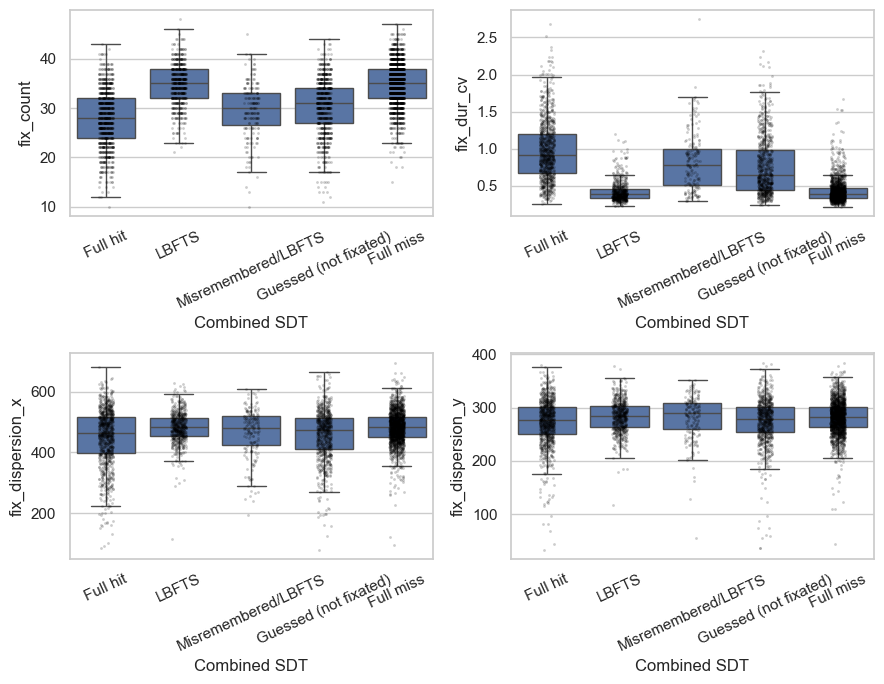

In [42]:
# Cell 13: boxplot — Combined SDT (5) in one figure with subplots (seaborn + strip)
if 'Combined SDT' in df.columns:
    cat5 = ['Full hit','LBFTS','Misremembered/LBFTS','Guessed (not fixated)','Full miss']
    y_vars = [c for c in ['fix_count','fix_dur_cv','fix_dispersion_x' ,'fix_dispersion_y'] if c in df.columns]
    # y_vars = [c for c in ['fix_dur_mean','fix_dur_cv','fix_count','first_look_time','fix_dispersion_x','fix_dispersion_y'] if c in df.columns]
    dd = df[df['Combined SDT'].isin(cat5)][['Combined SDT'] + y_vars].dropna(how='all')
    n = len(y_vars)
    if n:
        rows = int(np.ceil(n / 2)); cols = min(2, n)
        fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 3.5 * rows), squeeze=False)
        for i, y in enumerate(y_vars):
            r, c = divmod(i, cols)
            ax = axes[r][c]
            sns.boxplot(data=dd, x='Combined SDT', y=y, order=cat5, showfliers=False, ax=ax)
            sns.stripplot(data=dd, x='Combined SDT', y=y, order=cat5, color='black', alpha=0.2, size=2, ax=ax)
            ax.set_xlabel('Combined SDT'); ax.set_ylabel(y)
            ax.tick_params(axis='x', rotation=25)
        for j in range(i + 1, rows * cols):
            r, c = divmod(j, cols)
            axes[r][c].axis('off')
        plt.tight_layout()
        plt.show()

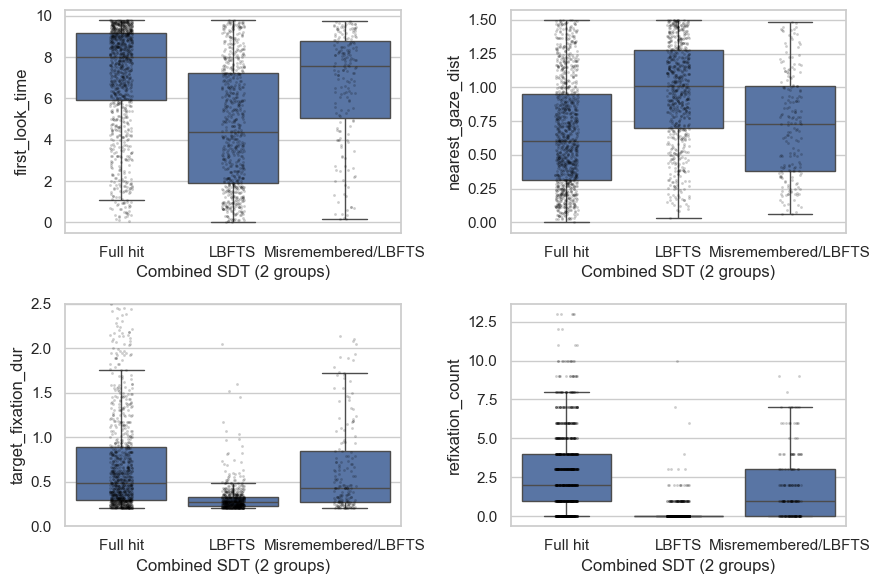

In [44]:
# Cell 14: boxplot — Full hit vs LBFTS (onset, nearest, target dur, refix) in one figure (seaborn + strip)
y_vars = [c for c in ['first_look_time','nearest_gaze_dist','target_fixation_dur','refixation_count'] if c in df.columns]
cat3 = ['Full hit','LBFTS','Misremembered/LBFTS']
dd2 = df[df['Combined SDT'].isin(cat3)][['Combined SDT'] + y_vars].dropna(how='all')
if not dd2.empty and y_vars:
    rows = int(np.ceil(len(y_vars) / 2)); cols = min(2, len(y_vars))
    fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 3 * rows), squeeze=False)
    for i, y in enumerate(y_vars):
        r, c = divmod(i, cols)
        ax = axes[r][c]
        sns.boxplot(data=dd2, x='Combined SDT', y=y, order=cat3, showfliers=False, ax=ax)
        sns.stripplot(data=dd2, x='Combined SDT', y=y, order=cat3, color='black', alpha=0.2, size=2, ax=ax)
        ax.set_xlabel('Combined SDT (2 groups)'); ax.set_ylabel(y)
        if y =='target_fixation_dur':
            ax.set_ylim(0, 2.5)
    for j in range(i + 1, rows * cols):
        r, c = divmod(j, cols)
        axes[r][c].axis('off')
    plt.tight_layout()
    plt.show()

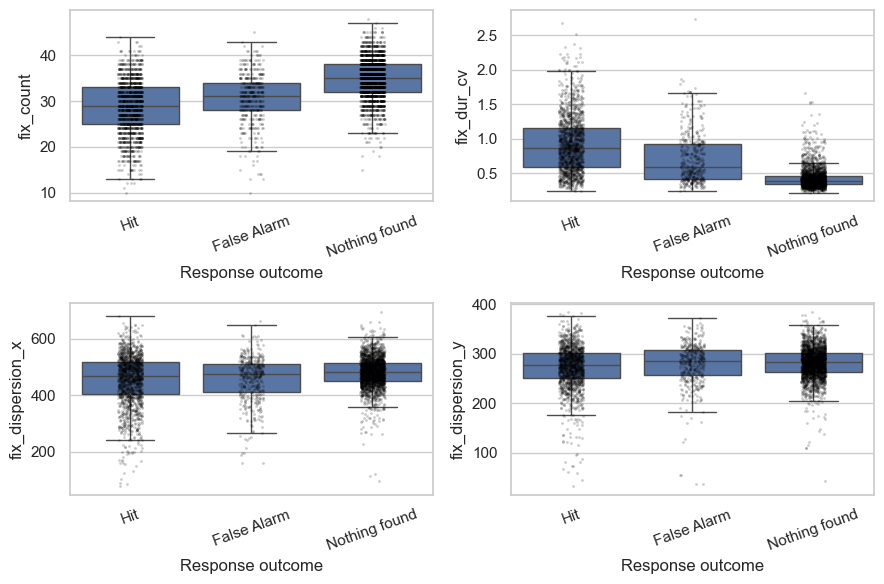

In [ ]:
# Cell 15: boxplot — Response outcome (Hit/FA/NF) one figure (seaborn + strip) + onset
if 'Response outcome' in df.columns:
    order = ['Hit','False Alarm','Nothing found']
    y_vars = [c for c in ['fix_count','fix_dur_cv','fix_dispersion_x' ,'fix_dispersion_y'] if c in df.columns]
    dd3 = df[df['Response outcome'].isin(order)][['Response outcome'] + y_vars].dropna(how='all')
    if not dd3.empty and y_vars:
        rows = int(np.ceil(len(y_vars) / 2)); cols = min(2, len(y_vars))
        fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), squeeze=False)
        for i, y in enumerate(y_vars):
            r, c = divmod(i, cols)
            ax = axes[r][c]
            sns.boxplot(data=dd3, x='Response outcome', y=y, order=order, showfliers=False, ax=ax)
            sns.stripplot(data=dd3, x='Response outcome', y=y, order=order, color='black', alpha=0.2, size=2, ax=ax)
            ax.set_xlabel('Response outcome'); ax.set_ylabel(y)
            ax.tick_params(axis='x', rotation=20)
        for j in range(i + 1, rows * cols):
            r, c = divmod(j, cols)
            axes[r][c].axis('off')
        plt.tight_layout()
        plt.show()

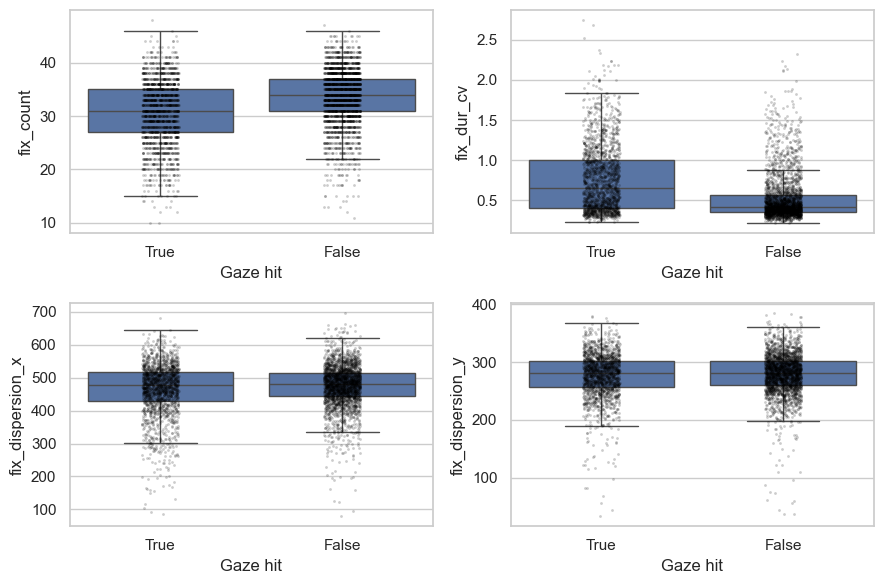

In [41]:
# Cell 16: boxplot — Gaze hit True/False one figure (seaborn + strip) + onset
if 'Gaze hit' in df.columns:
    df['Gaze_hit_label'] = df['Gaze hit'].map({True:'True', False:'False'})
    y_vars = [c for c in ['fix_count','fix_dur_cv','fix_dispersion_x' ,'fix_dispersion_y'] if c in df.columns]
    dd4 = df.dropna(subset=['Gaze_hit_label'])[['Gaze_hit_label'] + y_vars].dropna(how='all')
    if not dd4.empty and y_vars:
        rows = int(np.ceil(len(y_vars) / 2)); cols = min(2, len(y_vars))
        fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 3 * rows), squeeze=False)
        for i, y in enumerate(y_vars):
            r, c = divmod(i, cols)
            ax = axes[r][c]
            sns.boxplot(data=dd4, x='Gaze_hit_label', y=y, order=['True','False'], showfliers=False, ax=ax)
            sns.stripplot(data=dd4, x='Gaze_hit_label', y=y, order=['True','False'], color='black', alpha=0.2, size=2, ax=ax)
            ax.set_xlabel('Gaze hit'); ax.set_ylabel(y)
        for j in range(i + 1, rows * cols):
            r, c = divmod(j, cols)
            axes[r][c].axis('off')
        plt.tight_layout()
        plt.show()

